# **Segmentação de MRI Cardíacas**



# Dependências

Bibliotecas

In [ ]:
!pip install tensorflow==2.5.0

!pip install scikit-learn==0.24.2
!pip install segmentation-models==1.0.1

!pip install nibabel==3.2.1
!pip install MedPy==0.4.0

!pip install matplotlib==3.2.2

Acesso à arquivos do Gdrive

In [ ]:
drive_path = [
    '/content/drive',
    'My Drive/Colab Notebooks/data'
]

In [ ]:
import os, sys
from google.colab import drive

drive.mount(drive_path[0], force_remount=True)
os.chdir('/'.join(drive_path))
sys.path.append('/'.join(drive_path))

Visualização da GPU disponibilizada

In [ ]:
!nvidia-smi

Visualizando a quantidade de GPUs detectadas

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f'GPUs available: {len(gpus)}')

Configuração de uso gradual e necessário da memória da GPU utilizada

In [ ]:
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} physical GPUs vs. {len(logical_gpus)} logical GPUs')
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Constantes

In [ ]:
from tensorflow.data import AUTOTUNE
from os.path import join as join_path

In [ ]:
IMG_SZ = 200

In [ ]:
RANDOM_SEED = 42

Imagens

In [ ]:
# represent voxels located in the:
# 0: background
# 1: RV cavity
# 2: myocardium
# 3: LV cavity 
CLASSES_CNT = 4

In [ ]:
INPUT_CHANNELS = 1

In [ ]:
PATCH_STEP = 18

In [ ]:
IMG_SUFIX = '_data'

In [ ]:
MASK_SUFIX = '_mask'

In [ ]:
CLASS_WEIGHT_FILENAME = 'classes_weight.npy'
CLASS_WEIGHT_FILENAME = join_path(*drive_path, CLASS_WEIGHT_FILENAME)

Data-subgroup

In [ ]:
VALIDATION_PROPORTION = .25

In [ ]:
XVALIDATION_PROPORTION = .25

Datasets

In [ ]:
DT_BUFFER_SZ = 16

In [ ]:
PREFETCH_DATA_SZ = AUTOTUNE

In [ ]:
BASE_DATA_DIR = 'ACDC_2017_dados'

RAW_TRAINING_FILENAME = 'training.zip'
RAW_TRAINING_DIR = 'raw_train'
PATCHES_DIR = 'image_patches'
TRAINING_DIR = 'train'
X_VAL_DIR = 'validation'
TEST_DIR = 'test'

RAW_TRAINING_DIR = join_path(BASE_DATA_DIR, RAW_TRAINING_DIR)
TRAINING_DIR = join_path(BASE_DATA_DIR, PATCHES_DIR, TRAINING_DIR)
X_VAL_DIR = join_path(BASE_DATA_DIR, PATCHES_DIR, X_VAL_DIR)
TEST_DIR = join_path(BASE_DATA_DIR, PATCHES_DIR, TEST_DIR)

RAW_TRAINING_FILENAME = join_path(*drive_path, RAW_TRAINING_FILENAME)
RAW_TRAINING_DIR = join_path(*drive_path, RAW_TRAINING_DIR)
TRAINING_DIR = join_path(*drive_path, TRAINING_DIR)
X_VAL_DIR = join_path(*drive_path, X_VAL_DIR)
TEST_DIR = join_path(*drive_path, TEST_DIR)

In [ ]:
IMG_GLOB_SEARCH = ''.join(['*', IMG_SUFIX, '.npy'])

In [ ]:
MASK_GLOB_SEARCH = ''.join(['*', MASK_SUFIX, '.npy'])

Modelos

In [ ]:
MODEL_FILENAME = 'ulas_model'
MODEL_FILENAME = 'ulas_model_v2'
# MODEL_FILENAME = 'linknet_model'
# MODEL_FILENAME = 'unet_model'

In [ ]:
MODEL_DIR = join_path(*drive_path, MODEL_FILENAME)

Arquitetura Ulas

In [ ]:
POOL_SIZE = 2

Métricas e Funções de perda

In [ ]:
SMOOTH = 1e-3

In [ ]:
FOCAL_LOSS_GAMA = 2

Treinamento

In [ ]:
INIT_LEARNING_RATE = 1e-3

In [ ]:
MIN_LEARNING_RATE = 1e-6

In [ ]:
BATCH_SIZE = 32

In [ ]:
INITAL_EPOCH = 7

In [ ]:
MAX_EPOCH = 50

In [ ]:
MAIN_METRIC = 'dice_metric'

In [ ]:
if MODEL_FILENAME == 'unet_plusplus_model':
    EVAL_METRIC = f're_lu_{MAIN_METRIC}'
else:
    EVAL_METRIC = MAIN_METRIC

In [ ]:
METRIC_THRESHOLD = .5

Data augmentation

In [ ]:
AUG_ROTATION = 90

In [ ]:
AUG_W_HOR_FLIP = True

In [ ]:
AUG_W_VER_FLIP = True

In [ ]:
AUG_WIDTH_RNG = .4

In [ ]:
AUG_HEIGHT_RNG = .4

In [ ]:
AUG_ZOOM = [1, 1.6]

In [ ]:
AUG_FILL_MODE = 'wrap'

Milestones do treinamento

In [ ]:
EARLY_STOP_PATIENCE = 5

In [ ]:
LR_REDUCER_PATIENCE = 3

In [ ]:
STEPS_FILENAME = join_path(
    MODEL_DIR,
    f'{MODEL_FILENAME}.h5'
)

In [ ]:
CSV_LOG_FILENAME = join_path(MODEL_DIR, f'{MODEL_FILENAME}_log.csv')

Resultados

In [ ]:
PLOT_FILENAME = f'{MODEL_FILENAME}_structure.png'
PLOT_FILENAME = join_path(MODEL_DIR, PLOT_FILENAME)

In [ ]:
PLOT_WIDTH = 720

# Manipulação das imagens

Imports desta seção

In [ ]:
import os

import nibabel as nib
import numpy as np
import tensorflow as tf
from time import sleep
from numpy import unique
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.image import extract_patches
from tensorflow.keras.utils import normalize, to_categorical

Imagens originais, .nii.gz

In [ ]:
"""
author: Clément Zotti (clement.zotti@usherbrooke.ca)
date: April 2017

DESCRIPTION :
The script provide helpers functions to handle nifti image format:
    - load_nii()
    - save_nii()

to generate metrics for two images:
    - metrics()

And it is callable from the command line (see below).
Each function provided in this script has comments to understand
how they works.

HOW-TO:

This script was tested for python 3.4.

First, you need to install the required packages with
    pip install -r requirements.txt

After the installation, you have two ways of running this script:
    1) python metrics.py ground_truth/patient001_ED.nii.gz prediction/patient001_ED.nii.gz
    2) python metrics.py ground_truth/ prediction/

The first option will print in the console the dice and volume of each class for the given image.
The second option wiil ouput a csv file where each images will have the dice and volume of each class.


Based on: http://acdc.creatis.insa-lyon.fr
"""
#
# Utils function to load and save nifti files with the nibabel package
#
def load_nii(img_path):
    """
    Function to load a 'nii' or 'nii.gz' file, The function returns
    everyting needed to save another 'nii' or 'nii.gz'
    in the same dimensional space, i.e. the affine matrix and the header

    Parameters
    ----------

    img_path: string
    String with the path of the 'nii' or 'nii.gz' image file name.

    Returns
    -------
    Three element, the first is a numpy array of the image values,
    the second is the affine transformation of the image, and the
    last one is the header of the image.
    """
    nimg = nib.load(img_path)
    return nimg.get_fdata().astype('float32'), nimg.affine, nimg.header

def save_nii(img_path, data, affine, header):
    """
    Function to save a 'nii' or 'nii.gz' file.

    Parameters
    ----------

    img_path: string
    Path to save the image should be ending with '.nii' or '.nii.gz'.

    data: np.array
    Numpy array of the image data.

    affine: list of list or np.array
    The affine transformation to save with the image.

    header: nib.Nifti1Header
    The header that define everything about the data
    (pleasecheck nibabel documentation).
    """
    nimg = nib.Nifti1Image(data, affine=affine, header=header)
    nimg.to_filename(img_path)

Localização dos arquivos

In [ ]:
def file_paths(base_dir):
    c_paths = {
        'config': [],
        'ground_truth': [],
        'images': [],
        '4d': []
    }

    for c_dir, next_dirs, file_names in os.walk(base_dir):
        # skip root
        if next_dirs:
            continue

        c_patient = os.path.basename(c_dir)

        for f_n in file_names:
            f_n = os.path.join(c_dir, f_n)

            if f_n.endswith('.cfg'): file_type = 'config'
            elif '_gt' in f_n: file_type = 'ground_truth'
            elif '_4d' in f_n: file_type = '4d'
            else: file_type = 'images'

            c_paths[file_type].append(f_n)

    for file_type in c_paths.keys():
        c_paths[file_type].sort()

    return c_paths

Conversões diretas salvas

In [ ]:
def load_data(file_paths, is_training=True):
    images_filename = os.path.join(*drive_path, f'{"training" if is_training else "test"}_data.npy')
    gt_filename = os.path.join(*drive_path, f'{"training" if is_training else "test"}_gt_data.npy')

    try:
        imgs = np.load(images_filename, allow_pickle=True)
        imgs_gt = np.load(gt_filename, allow_pickle=True)

        if np.any(imgs) and np.any(imgs_gt):
            print('carregado dos arquivos')

            return tf.convert_to_tensor(imgs), tf.convert_to_tensor(imgs_gt, dtype=tf.float32)
    except:
        print('lendo imagens arquivos')
        imgs, imgs_gt =  _load_data(file_paths)

        # np.save(images_filename, imgs)
        # np.save(gt_filename, imgs_gt)

        return imgs, imgs_gt

def load_classes_weight(labels=None):
    return None
    try:
        weights = np.load(CLASS_WEIGHT_FILENAME, allow_pickle=True)

        if np.any(weights):
            print('carregado do arquivo')

            return weights
    except:
        print('calculando pesos')
        if not np.any(labels):
            return None

        weights = compute_class_weight(
            'balanced',
            np.arange(CLASSES_CNT),
            tf.reshape(tf.cast(labels, tf.int8), [-1]).numpy()
        )

        np.save(CLASS_WEIGHT_FILENAME, weights)

        return weights

Pré-processamento das imagens originais

In [ ]:
def _load_data(file_paths):
    images, ground_truth = [], []
    cnt = 1

    for c_img, c_ground_truth in zip(file_paths['images'], file_paths['ground_truth']):
        print(f'processing {cnt}...')

        # we load 3D training image
        training_image, _, _ = load_nii(c_img)
        # we load 3D training mask (shape=(512,512,129))
        train_ground_truth, _, _ = load_nii(c_ground_truth)

        for k in range(min(train_ground_truth.shape[-1], training_image.shape[-1])):
            #axial cuts are made along the z axis with undersampling
            gt_2d = np.array(train_ground_truth[::, ::, k])

            # invalid ground truth
            if len(np.unique(gt_2d)) == 1:
                continue

            image_patches = _extract_patches(
                _pre_process_img(np.array(training_image[::, ::, k]))
            )
            gt_patches = _extract_patches(gt_2d)

            if (tf.size(images) == 0).numpy():
                images = image_patches
            else:
                images = tf.concat((images, image_patches), axis=0)

            if (tf.size(ground_truth) == 0).numpy():
                ground_truth = gt_patches
            else:
                ground_truth = tf.concat((ground_truth, gt_patches), axis=0)

        cnt += 1

    return images, ground_truth

def _extract_patches(image_2d):
    image_2d = tf.expand_dims(tf.expand_dims(image_2d, axis=-1), axis=0)

    if image_2d.shape[1] < IMG_SZ or image_2d.shape[2] < IMG_SZ:
        return tf.image.resize(
            image_2d, (IMG_SZ, IMG_SZ), method='nearest'
        )

    image_patches = extract_patches(
        image_2d,
        sizes=[1, IMG_SZ, IMG_SZ, 1],
        strides=[1, PATCH_STEP, PATCH_STEP, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    return tf.reshape(
        image_patches,
        [image_patches.shape[1] * image_patches.shape[2], IMG_SZ, IMG_SZ, 1]
    )

# Based on: https://github.com/MinaJf/FU-net/blob/HEAD/image_loder.py
def _pre_process_img(img):
    img = tf.cast(img, tf.float32)

    # standardization (zero mean)
    img -= tf.math.reduce_mean(img)
    img /= tf.math.reduce_std(img)

    # normalize between [0, 1]
    img -= tf.math.reduce_min(img)
    img /= tf.math.reduce_max(img)

    return img

In [ ]:
def save_patches(patches, base_dir, is_label=False):
    for ind, img in enumerate(patches, start=1):
        img_name = f'{ind}{MASK_SUFIX if is_label else IMG_SUFIX}'
        img_path = os.path.join(base_dir, img_name)

        np.save(img_path, img)
        # while True:
        #     print(f'\t a salvar...')
        #     sleep(2)

        #     if os.path.exists(img_path): break
            
        print(f'saved {img_path}')

# Manipulação dos dados

In [ ]:
from tensorflow.data import Dataset
from tensorflow.keras.utils import to_categorical
from numpy import load
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.preprocessing.image as img_preprocessing

In [ ]:
def check_cnt(main_path):
    img_cnt = len(glob(os.path.join(main_path, IMG_GLOB_SEARCH)))
    mask_cnt = len(glob(os.path.join(main_path, MASK_GLOB_SEARCH)))

    print('img_cnt', img_cnt)
    print('mask_cnt', mask_cnt)

    return img_cnt if img_cnt == mask_cnt else 0

In [ ]:
def _load_images(img_path):
    img_path = img_path.decode()

    image = load(img_path, allow_pickle=True)

    mask_path = img_path.replace(IMG_SUFIX, MASK_SUFIX)
    
    mask = load(mask_path, allow_pickle=True)

    return image, mask

In [ ]:
@tf.function
def ensure_shape(image, mask):
    image = tf.convert_to_tensor(image)
    mask = tf.convert_to_tensor(mask)

    image.set_shape((IMG_SZ, IMG_SZ, 1))
    mask.set_shape((IMG_SZ, IMG_SZ, 1))

    return image, mask

In [ ]:
@tf.function
def pre_processing(image, mask):
    mask = tf.cast(mask, tf.int32)
    mask = tf.one_hot(mask, CLASSES_CNT)
    mask = tf.squeeze(mask)

    return image, mask

In [ ]:
@tf.function
def data_augmentation(image, mask):
	# fill_mode="wrap"

    # horizontal_flip=True,
    image = tf.image.random_flip_left_right(image)
    # vertical_flip=True,
    image = tf.image.random_flip_up_down(image)

    # # width_shift_range=.4,
    # # height_shift_range=.4,
    
    image = img_preprocessing.random_shift(
        np.array(img_preprocessing.array_to_img(image)), .4, .4, fill_mode='wrap'
    )

    # # rotation_range=90,
    # image = img_preprocessing.random_rotation(image, 90, fill_mode='wrap')

    # # zoom_range=[1, 1.6],
    # image = img_preprocessing.random_zoom(image, (1, 1.6))

    # tf.compat.v1.disable_eager_execution()

    return tf.convert_to_tensor(image), mask

In [ ]:
def get_dataset(main_path, is_allowed_to_shuffle=False):
    dataset = Dataset.list_files(os.path.join(main_path, IMG_GLOB_SEARCH), shuffle=True, seed=RANDOM_SEED)
    
    if is_allowed_to_shuffle:
        dataset = dataset.shuffle(
            buffer_size=DT_BUFFER_SZ,
            seed=RANDOM_SEED,
            reshuffle_each_iteration=True
        )

    dataset = dataset.map(lambda x: tf.numpy_function(_load_images, [x], (tf.float32, tf.float32)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(ensure_shape, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    
    dataset = dataset.map(pre_processing, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.repeat()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
def display_sample(display_list, to_save=False):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(dpi=180)
    plt.figure(figsize=(10, 10))

    if len(display_list) == 3:
        equal = display_list[1] * display_list[2]
        
        display_list.append(equal)
        display_list.append(display_list[1] - equal)
        display_list.append(display_list[2] - equal)

    settings = [
        { # 0
            'title': 'Input Image',
            'pre_processing': lambda x: tf.squeeze(x, axis=2),
        },
        { # 1
            'title': 'Ground Truth',
            'pre_processing': lambda x: tf.argmax(x, axis=2),
        },
        { # 2
            'title': 'Prediction',
            'pre_processing': lambda x: tf.argmax(x, axis=2),
        },
        { # 3
            'title': 'Match',
            'pre_processing': lambda x: tf.argmax(x, axis=2),
        },
        { # 4
            'title': 'G.T. - Match',
            'pre_processing': lambda x: tf.argmax(x, axis=2),
        },
        { # 5
            'title': 'Pred. - Match',
            'pre_processing': lambda x: tf.argmax(x, axis=2),
        },
    ]

    for ind, image in enumerate(display_list):
        plt.subplot(1, len(display_list), ind + 1)
        plt.title(settings[ind]['title'])
        plt.imshow(settings[ind]['pre_processing'](image), cmap='hot')
        plt.axis('off')

    if to_save and len(display_list) == len(settings):
        plt.savefig(os.path.join(MODEL_DIR, f'comparativo.svg'), dpi=300)
        plt.savefig(os.path.join(MODEL_DIR, f'comparativo.png'), dpi=300)

    plt.show()

# Modelo em mémoria

Imports da seção

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
# Based on: https://github.com/mjbhobe/dl-tensorflow-keras/blob/master/kr_helper_funcs.py
def save_model(model, file_name, save_dir):
    """ save the model structure to JSON & weights to HD5 """
    # check if save_dir exists, else create it
    if not os.path.exists(save_dir):
        try:
            mkdir(save_dir)
        except OSError as err:
            print(f'Não foi possível criar o repositório "{save_dir}", para salvar o modelo. Terminando a execução!')
            raise err

    # model structure is saved to $(save_dir)/base_file_name.json
    # weights are saved to $(save_dir)/base_file_name.h5
    model_json = model.to_json()
    json_file_path = os.path.join(save_dir, (file_name + ".json"))
    h5_file_path = os.path.join(save_dir, (file_name + '.h5'))

    with open(json_file_path, "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5\n",
    model.save(
        h5_file_path,
        overwrite=True,
        include_optimizer=True,
        signatures=None,
        options=None,
        save_traces=True,
    )

    print(f'Modelo salvo nos arquivos: "{json_file_path}" e "{h5_file_path}" ')

def load_model(file_name, load_dir):
    """ loads model structure & weights from previously saved state """
    # model structure is loaded $(load_dir)/base_file_name.json
    # weights are loaded from $(load_dir)/base_file_name.h5

    # load model from save_path
    loaded_model = None
    json_file_path = os.path.join(load_dir, (file_name + ".json"))
    h5_file_path = os.path.join(load_dir, (file_name + ".h5"))

    if os.path.exists(json_file_path) and os.path.exists(h5_file_path):
        with open(json_file_path, "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = model_from_json(loaded_model_json)
            loaded_model.load_weights(h5_file_path)

        print(f'Modelo construído a partir dos arquivos: "{json_file_path}" e "{h5_file_path}"')

    else:
        print(
            f'Arquivos não encontrados: "{(file_name + ".json")}" e "{(file_name + ".h5")}", na pasta "{load_dir}"'
        )

    return loaded_model

# Métricas manuais

Imports da seção

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
def inter_union_sum(y_true, y_pred):
    # W,H axes of each image
    axes = (1,2)
    
    intersection = K.sum(K.abs(y_pred * y_true), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection

    return intersection, union, mask_sum

In [ ]:
def dice_metric(y_true, y_pred):
    # 2*|A & B| / (|A| + |B|)
    intersection, _, mask_sum = inter_union_sum(y_true, y_pred)

    dice = 2 * (intersection + SMOOTH)/(mask_sum + SMOOTH)

    return K.mean(dice)

In [ ]:
def jaccard_metric(y_true, y_pred):
    # |A & B| / (| A U B|)
    intersection, union, _ = inter_union_sum(y_true, y_pred)

    jaccard = (intersection + SMOOTH) / (union + SMOOTH)

    return K.mean(jaccard)

# Arquiteturas conhecidas

Imports da seção

In [ ]:
from segmentation_models import Linknet, Unet, set_framework

In [ ]:
set_framework('tf.keras')

In [ ]:
def get_linknet_model(num_classes=1, backbone='resnet34'):
    return Linknet(
        backbone,
        encoder_weights='imagenet',
        classes=num_classes,
        activation='softmax' if num_classes > 1 else 'sigmoid'
    )

In [ ]:
def get_unet_model(num_classes=1, backbone='resnet34'):
    return Unet(
        backbone,
        encoder_weights='imagenet',
        classes=num_classes,
        activation='softmax' if num_classes > 1 else 'sigmoid'
    )

# Arquitetura proposto por Ulas

Imports da seção

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import (Activation, AveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D,
                                     UpSampling2D, concatenate)
from tensorflow.keras.models import Sequential

In [ ]:
def _get_ulas_item_dense_layer(inputs, filters, kernel):
    conv = Conv2D(
        filters=filters,
        kernel_size=kernel,
        padding='same',
        use_bias=False
    )(inputs)
    bn = BatchNormalization()(conv)
    act = Activation(swish)(bn)

    return act

In [ ]:
def _get_ulas_dense_layer(input, conv_confs):
    fst = _get_ulas_item_dense_layer(input, *conv_confs[0])
    snd = _get_ulas_item_dense_layer(concatenate([input, fst]), *conv_confs[1])
    trd = _get_ulas_item_dense_layer(concatenate([input, fst, snd]), *conv_confs[2])
    frt = _get_ulas_item_dense_layer(concatenate([input, fst, snd, trd]), *conv_confs[3])

    return frt

In [ ]:
def get_ulas_model(num_classes=1, pool_size=POOL_SIZE):
    input = Input(
        shape=(IMG_SZ, IMG_SZ, INPUT_CHANNELS),
        dtype='float32'
    )

    # 1º parte do encoder
    dense1 = _get_ulas_dense_layer(
        input,
        [
            (160, (3, 7)),
            (112, (3, 7)),
            (144, (9, 7)),
            (80, (3, 11)),
        ]
    )
    trans1 = MaxPooling2D(pool_size=(pool_size, pool_size))(dense1)

    # 2º parte do encoder
    dense2 = _get_ulas_dense_layer(
        trans1, 
        [
            (144, (3, 5)),
            (176, (7, 1)),
            (144, (9, 9)),
            (96, (3, 3)),
        ]
    )
    trans2 = AveragePooling2D(pool_size=(pool_size, pool_size))(dense2)

    # 1º parte da ponte
    dense3 = _get_ulas_dense_layer(
        trans2, 
        [
            (176, (1, 1)),
            (128, (3, 5)),
            (208, (7, 7)),
            (212, (3, 3)),
        ]
    )

    # 2º parte da ponte
    dense4 = _get_ulas_dense_layer(
        dense3, 
        [
            (64, (1, 7)),
            (208, (3, 5)),
            (64, (9, 5)),
            (208, (7, 9)),
        ]
    )

    # 1º parte do decoder
    trans3 = UpSampling2D(size=(pool_size, pool_size))(dense4)
    dense5 = _get_ulas_dense_layer(
        trans3, 
        [
            (208, (5, 7)),
            (64, (3, 5)),
            (96, (11, 11)),
            (112, (7, 7)),
        ]
    )

    # 2º parte do decoder
    trans4 = UpSampling2D(size=(pool_size, pool_size))(dense5)
    dense6 = _get_ulas_dense_layer(
        trans4, 
        [
            (128, (5, 5)),
            (80, (11, 7)),
            (64, (1, 1)),
            (16, (3, 7)),
        ]
    )

    final = Conv2D(
        filters=num_classes,
        kernel_size=(3, 7),
        padding='same',
        activation='softmax'
    )(dense6)

    model = Model(inputs=input, outputs=final)

    return model

# Dependências de Treinamento



Imports da seção

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from segmentation_models.losses import DiceLoss, CategoricalFocalLoss
from segmentation_models.metrics import IOUScore, FScore

In [ ]:
optimizer = Adam(
    learning_rate=INIT_LEARNING_RATE
)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=AUG_ROTATION,
    horizontal_flip=AUG_W_HOR_FLIP,
    vertical_flip=AUG_W_VER_FLIP,
    width_shift_range=AUG_WIDTH_RNG,
    height_shift_range=AUG_HEIGHT_RNG,
    zoom_range=AUG_ZOOM,
	fill_mode=AUG_FILL_MODE
)

In [ ]:
def loss_func(class_weights):
    dice_loss = DiceLoss(class_weights=class_weights, smooth=SMOOTH)
    focal_loss = CategoricalFocalLoss(gamma=FOCAL_LOSS_GAMA)

    return dice_loss + focal_loss

In [ ]:
def metric_func(class_weights):
    return [
        dice_metric,
        jaccard_metric,
        'accuracy',
        'categorical_accuracy',
        MeanIoU(num_classes=CLASSES_CNT),
        IOUScore(class_weights=class_weights, smooth=SMOOTH, threshold=METRIC_THRESHOLD),
        FScore(smooth=SMOOTH, threshold=METRIC_THRESHOLD)
    ]

In [ ]:
def compile_model(model, class_weights=[]):
    model.compile(
        optimizer=optimizer,
        # 'categorical_crossentropy' | 'sparse_categorical_crossentropy'
        # https://keras.io/api/losses/probabilistic_losses/
        # loss='categorical_crossentropy',
        loss=loss_func(class_weights),
        # https://keras.io/api/metrics/
        metrics=metric_func(class_weights)
    )

    return model

Callbacks

In [ ]:
epoch_milestone = ModelCheckpoint(
    STEPS_FILENAME,
    monitor=f'val_{EVAL_METRIC}',
    save_best_only=True,
    mode='max',
    verbose=1,
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE,
    verbose=1,
)

In [ ]:
csv_logger = CSVLogger(
    CSV_LOG_FILENAME,
    separator=';',
    append=True,
)

In [ ]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    patience=LR_REDUCER_PATIENCE,
    min_lr=MIN_LEARNING_RATE,
    factor=1e-1,
    verbose=1
)

In [ ]:
callbacks = [
    epoch_milestone,
    early_stop,
    csv_logger,
    lr_reducer,
]

# Carregando dados



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_cnt = check_cnt(TRAINING_DIR)
train_cnt

In [ ]:
xval_cnt = check_cnt(X_VAL_DIR)
xval_cnt

In [ ]:
test_cnt = check_cnt(TEST_DIR)
test_cnt

In [ ]:
there_are_preload_data = all([train_cnt, test_cnt, xval_cnt])
there_are_preload_data

Procedimentos na ausência de dados

In [ ]:
if not there_are_preload_data:
    training_paths = file_paths(RAW_TRAINING_DIR)

In [ ]:
if not there_are_preload_data:
    raw_train_data, raw_train_labels = load_data(training_paths)

    print(f'raw_train_data: {raw_train_data.shape}\n\t{raw_train_data.dtype}')
    print(f'raw_train_labels: {raw_train_labels.shape}\n\t{raw_train_labels.dtype}')

In [ ]:
if not there_are_preload_data:
    classes_weight = load_classes_weight(raw_train_labels)
else:
    classes_weight = load_classes_weight()

print(f'classes_weight:\n{classes_weight}')

In [ ]:
if not there_are_preload_data:
    train_data, test_data, train_labels, test_labels = train_test_split(
        raw_train_data.numpy(), raw_train_labels.numpy(),
        test_size=VALIDATION_PROPORTION,
        random_state=RANDOM_SEED
    )

In [ ]:
if not there_are_preload_data:
    train_data, xval_data, train_labels, xval_labels = train_test_split(
        train_data, train_labels,
        test_size=XVALIDATION_PROPORTION,
        random_state=RANDOM_SEED
    )

In [ ]:
if not there_are_preload_data:
    print(f'train_data: {train_data.shape} - {train_data.dtype}')
    print(f'train_labels: {train_labels.shape} - {train_labels.dtype}')
    
    print(f'xval_data: {xval_data.shape} - {xval_data.dtype}')
    print(f'xval_labels: {xval_labels.shape} - {xval_labels.dtype}')

    print(f'test_data: {test_data.shape} - {test_data.dtype}')
    print(f'test_labels: {test_labels.shape} - {test_labels.dtype}')

In [ ]:
if not there_are_preload_data:
    save_patches(train_labels, TRAINING_DIR, is_label=True)
    save_patches(train_data, TRAINING_DIR)

In [ ]:
if not there_are_preload_data:
    save_patches(xval_labels, X_VAL_DIR, is_label=True)
    save_patches(xval_data, X_VAL_DIR)

In [ ]:
if not there_are_preload_data:
    save_patches(test_labels, TEST_DIR, is_label=True)
    save_patches(test_data, TEST_DIR)

In [ ]:
if not there_are_preload_data:
    del training_paths
    del train_data
    del train_labels
    del xval_data
    del xval_labels
    del test_data
    del test_labels

In [ ]:
if not there_are_preload_data:
    train_cnt = check_cnt(TRAINING_DIR)
    train_cnt

    xval_cnt = check_cnt(X_VAL_DIR)
    xval_cnt

    test_cnt = check_cnt(TEST_DIR)
    test_cnt

In [ ]:
train_dataset = get_dataset(TRAINING_DIR, is_allowed_to_shuffle=True)
train_dataset

TypeError: ignored

In [ ]:
xval_dataset = get_dataset(X_VAL_DIR)
xval_dataset

<BatchDataset shapes: ((None, 200, 200, 1), (None, 200, 200, 4)), types: (tf.float32, tf.float32)>

In [ ]:
test_dataset = get_dataset(TEST_DIR)
test_dataset

<BatchDataset shapes: ((None, 200, 200, 1), (None, 200, 200, 4)), types: (tf.float32, tf.float32)>

## Visualização teste

min tf.Tensor(0.0, shape=(), dtype=float32)
max tf.Tensor(0.14440733, shape=(), dtype=float32)


<Figure size 1080x720 with 0 Axes>

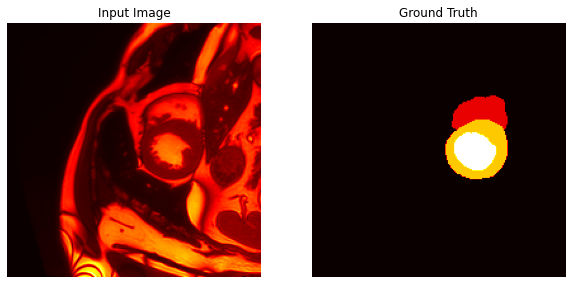

In [ ]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask

    print('min', tf.math.reduce_min(sample_image[0]))
    print('max', tf.math.reduce_max(sample_image[0]))

display_sample([sample_image[0], sample_mask[0]])

# Carregando model

Imports da seção

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model

In [ ]:
get_model = f'get_{MODEL_FILENAME}'

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
clear_session()

In [ ]:
model = load_model(MODEL_FILENAME, MODEL_DIR) or eval(get_model)(CLASSES_CNT)

Modelo construído a partir dos arquivos: "/content/drive/My Drive/Colab Notebooks/data/ulas_model/ulas_model.json" e "/content/drive/My Drive/Colab Notebooks/data/ulas_model/ulas_model.h5"


In [ ]:
model = compile_model(model, classes_weight)

In [ ]:
# save_model(model, MODEL_FILENAME, MODEL_DIR)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 160 3360        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 160 640         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 200, 160 0           batch_normalization[0][0]        
______________________________________________________________________________________________

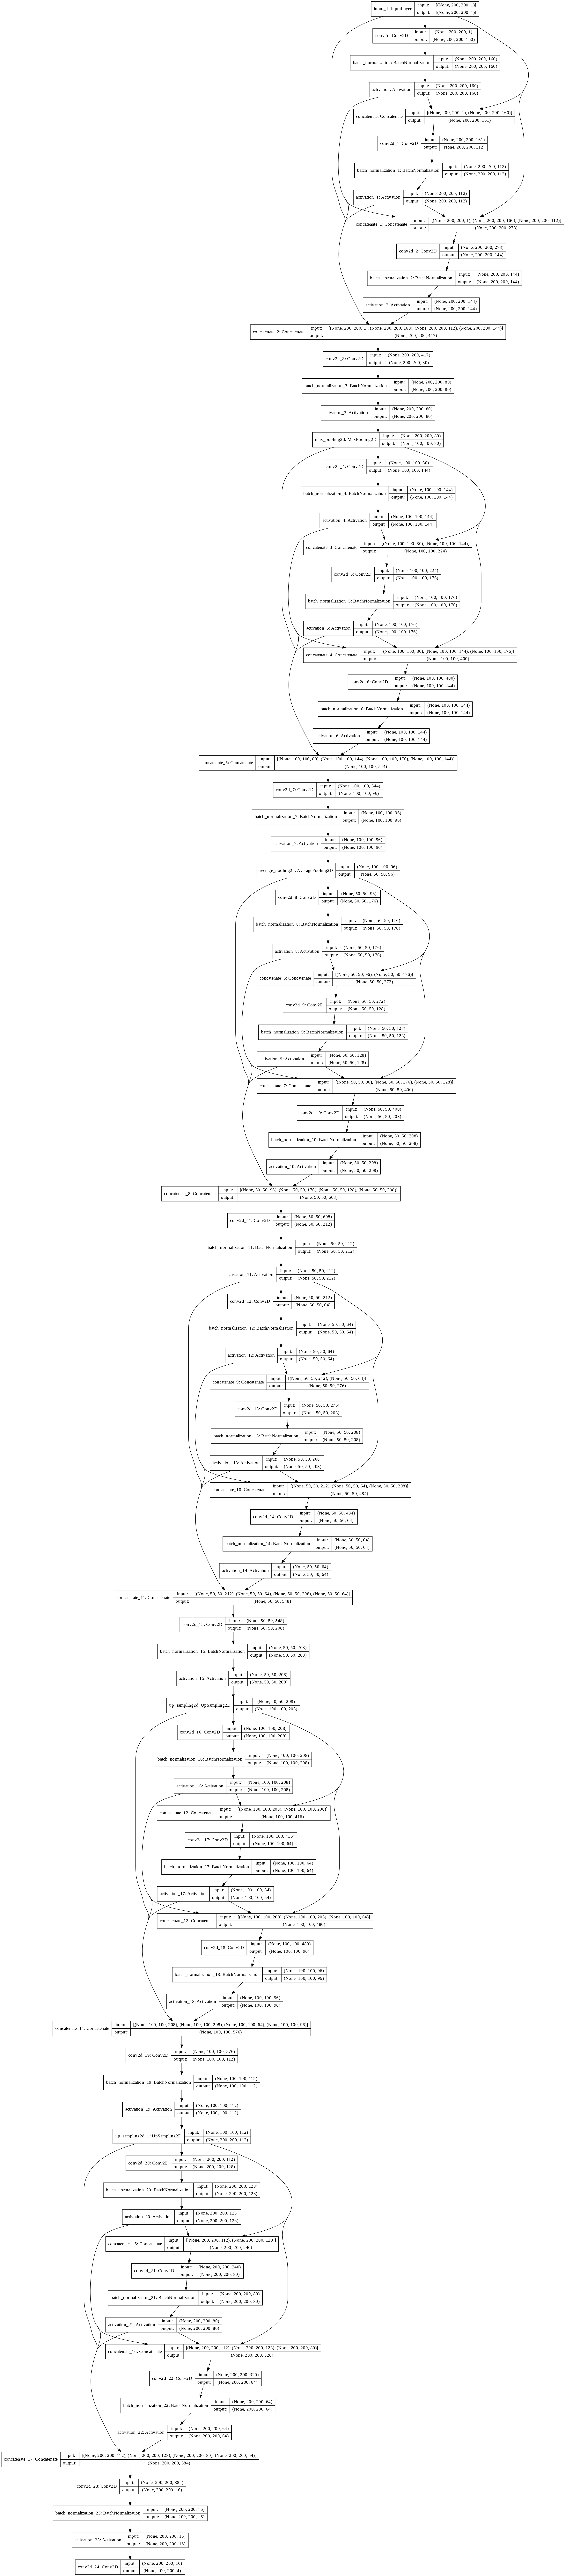

In [ ]:
plot_model(
    model,
    to_file=PLOT_FILENAME,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=120,
)

# Visualização prévia

In [ ]:
# import matplotlib.pyplot as plt
# from random import randint

In [ ]:
# plt.figure(dpi=180)

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

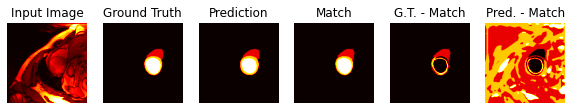

In [ ]:
# for image, mask in xval_dataset.take(1):
#     sample_image, sample_mask = image, mask

# predict_img = tf.convert_to_tensor(model.predict(sample_image))

# display_sample([sample_image[0], sample_mask[0], predict_img[0]], to_save=False)

# Treinamento

In [ ]:
STEPS_PER_EPOCH = train_cnt // BATCH_SIZE
STEPS_PER_EPOCH

1134

In [ ]:
VALIDATION_STEPS = xval_cnt // BATCH_SIZE
VALIDATION_STEPS 

379

In [ ]:
results = model.fit(
    # x=aug.flow(train_data, train_labels, batch_size=BATCH_SIZE, seed=RANDOM_SEED),
    train_dataset,
    initial_epoch=INITAL_EPOCH,
    epochs=MAX_EPOCH,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_data=(xval_data, xval_labels),
    validation_data=xval_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks
)

Epoch 8/50


In [ ]:
save_model(model, MODEL_FILENAME, MODEL_DIR)

In [ ]:
print(results.history)

# Visualização final

In [ ]:
import matplotlib.pyplot as plt
from random import randint

In [ ]:
plt.figure(dpi=180)

In [ ]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

predict_img = tf.convert_to_tensor(model.predict(sample_image))

display_sample([sample_image[0], sample_mask[0], predict_img[0]], to_save=True)